**IMPORT LIBRARIES**

In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import time
from PIL import ImageOps, Image
from typing import Tuple, Dict, Callable, Optional, Union, List
from datetime import datetime
import json

from src.utils.data_localisation import is_kaggle, find_capstone_dir
from src.utils.seed import set_seed
from src.utils.data_preparation import pad_image_if_needed, get_random_crop_coords, crop_image, crop_image_and_masks
from src.utils.data_sample_review import tensor_to_image,show_random_sample
from src.utils.data_model import dice_coefficient
from src.utils.data_visualisations import plot_dice_coefficients, plot_learning_curve
from src.utils.data_visualisations import visualize_predictions
from src.utils.data_model import calculate_averages_per_class,print_averages,calculate_overall_average,print_summary,calculate_dice_for_report,calculate_loss_for_report
from src.utils.information import update_report
from src.utils.early_stopping_module import EarlyStopping

#### PARAMETERS CONFIGURATION

In [2]:
class CFG:
    experiment_id           = 'JM53'
    model_name              = 'UNet'
    train_continuation      = False
    pretrained_model_path   = 'type_your_model_directory_here'
    early_stopping          = False
    es_patience             = 3
    es_delta                = 0.002
    train_bs                = 1
    valid_bs                = 1
    crop_size               = (16 , 16)
    num_crops               = 8
    epochs                  = 1
    lr                      = 0.0001
    data_train_test_split   = 0.9
    data_train_val_split    = 0.8
    device                  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    mask_train              = False
    cancerous_train         = True
    hard_to_classify_train  = False
    inflammatory_train      = False
    stroma_train            = False
    
enabled_masks = {
    "cancerous": CFG.cancerous_train,
    "hard_to_classify": CFG.hard_to_classify_train,
    "inflammatory": CFG.inflammatory_train,
    "stroma": CFG.stroma_train
}
class_names = [name for name, enabled in enabled_masks.items() if enabled]
num_masks = sum([CFG.mask_train, CFG.cancerous_train, CFG.hard_to_classify_train, CFG.inflammatory_train, CFG.stroma_train])

#### DATA LOCALISATION

In [3]:
if is_kaggle():
    dataset_path = '/kaggle/input/'
    reports_dir = '/kaggle/working/'
    models_dir = '/kaggle/working/'
else:
    base_dir = os.getcwd()
    capstone_dir = find_capstone_dir(base_dir)
    os.makedirs(os.path.join(capstone_dir, 'src', 'models'), exist_ok=True)
    os.makedirs(os.path.join(capstone_dir, 'src', 'reports'), exist_ok=True)
    os.makedirs(os.path.join(capstone_dir, 'src', 'data'), exist_ok=True)
    dataset_path = os.path.join(capstone_dir, 'src', 'data')
    models_dir = os.path.join(capstone_dir, 'src', 'models')
    reports_dir = os.path.join(capstone_dir, 'src', 'reports')

In [4]:
allocated_memory = torch.cuda.memory_allocated()
GPU_used = round(allocated_memory / 1024**3, 2)

#### CREATING DATASETS

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mask_config = {
    "cancerous": CFG.cancerous_train,
    "hard_to_classify": CFG.hard_to_classify_train,
    "inflammatory": CFG.inflammatory_train,
    "stroma": CFG.stroma_train,
    "mask": CFG.mask_train
}

**CROPPING**

In [6]:
class HistopathologyDataset(Dataset):
    def __init__(self, root_dir:str, mask_config:Dict[str,bool], transform:Optional[Callable[[Image.Image], Image.Image]]=False):
        """
        Args:
            root_dir (str): Katalog z obrazami i maskami.
            mask_config (dict): Słownik konfiguracji masek, gdzie klucze to nazwy masek, a wartości to True/False.
            transform (callable, optional): Transformacje do zastosowania na obrazie i maskach.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.mask_config = mask_config
        self.crop_size = CFG.crop_size
        self.num_crops = CFG.num_crops
        
        self.image_paths = []
        self.mask_paths = {key: [] for key in mask_config.keys() if mask_config[key]}

        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith("ROI.png"):
                    image_path = os.path.join(subdir, file)
                    mask_base_path = image_path.replace("ROI.png", "")
                    
                    for mask_type in self.mask_config.keys():
                        if self.mask_config[mask_type]:
                            mask_path = mask_base_path + mask_type.upper() + ".png"
                            self.mask_paths[mask_type].append(mask_path)
                    
                    self.image_paths.append(image_path)

    def __len__(self) -> int:
        
        return len(self.image_paths) * self.num_crops

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Image.Image]]:
        
        image_idx = idx // self.num_crops
        crop_idx = idx % self.num_crops

        image = Image.open(self.image_paths[image_idx]).convert("RGB")
            
        masks = {}
        for mask_type in self.mask_config.keys():
            if self.mask_config.get(mask_type, False):
                mask_path = self.mask_paths[mask_type][image_idx]
                mask = Image.open(mask_path).convert("L")
                masks[mask_type] = mask
        
        crop_coords = get_random_crop_coords(image.size, self.crop_size)
        cropped_image, cropped_masks = crop_image_and_masks(image, masks, crop_coords)
    
        if self.transform:                
            cropped_image = self.transform(cropped_image)
        
            mask_transforms = transforms.Compose([transforms.ToTensor()])
            cropped_masks = {
                key: (mask_transforms(mask) > 0).float() for key, mask in cropped_masks.items()
            }
          
            cropped_masks = dict(sorted(cropped_masks.items()))
        
        return cropped_image, cropped_masks


# DATASET - SPLIT & LOAD

**TRAIN VAL TEST**

In [7]:
set_seed(42)

In [8]:
### train vs test
dataset = HistopathologyDataset(root_dir=dataset_path, mask_config=mask_config, transform=transform)
train_val_size = int(CFG.data_train_test_split* len(dataset))
test_size = len(dataset) - train_val_size
trainval_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_val_size, test_size])

train_loader = DataLoader(trainval_dataset, batch_size=CFG.train_bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, shuffle=False)

## train vs val
train_size = int(CFG.data_train_val_split* len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.valid_bs, shuffle=False)

In [9]:
test_loader

# ARCHITECTURE U-NET

**ARCHITECTURE IMPLEMENTATION**

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels: int, num_masks: int) -> None:
        super(UNet, self).__init__()

        self.num_masks = num_masks
        
        def conv_block(in_ch: int, out_ch: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_ch: int, out_ch: int) -> nn.ConvTranspose2d:
            return nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = up_conv(1024, 512)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = up_conv(512, 256)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_masks, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        output_logit = self.final_conv(dec1)
        
        return output_logit

**DATASET PRESENTATION (INPUT)**

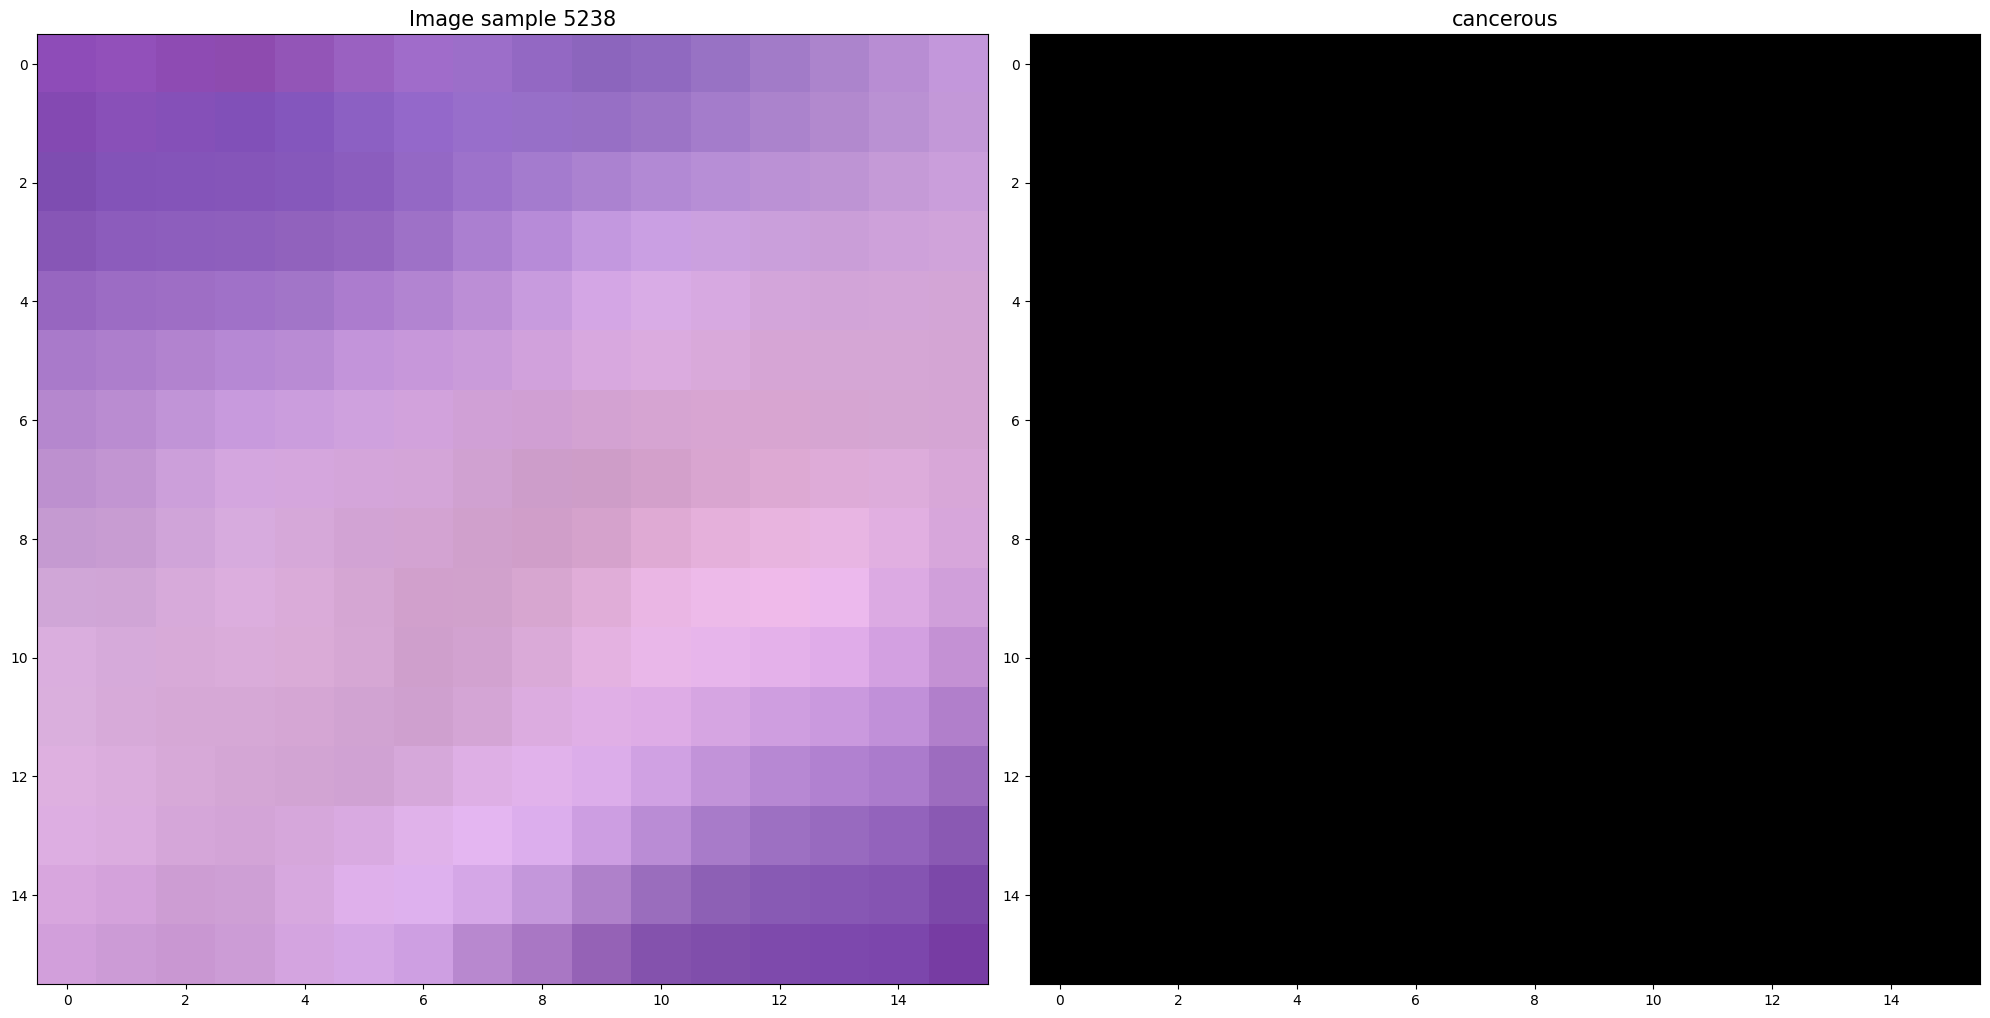

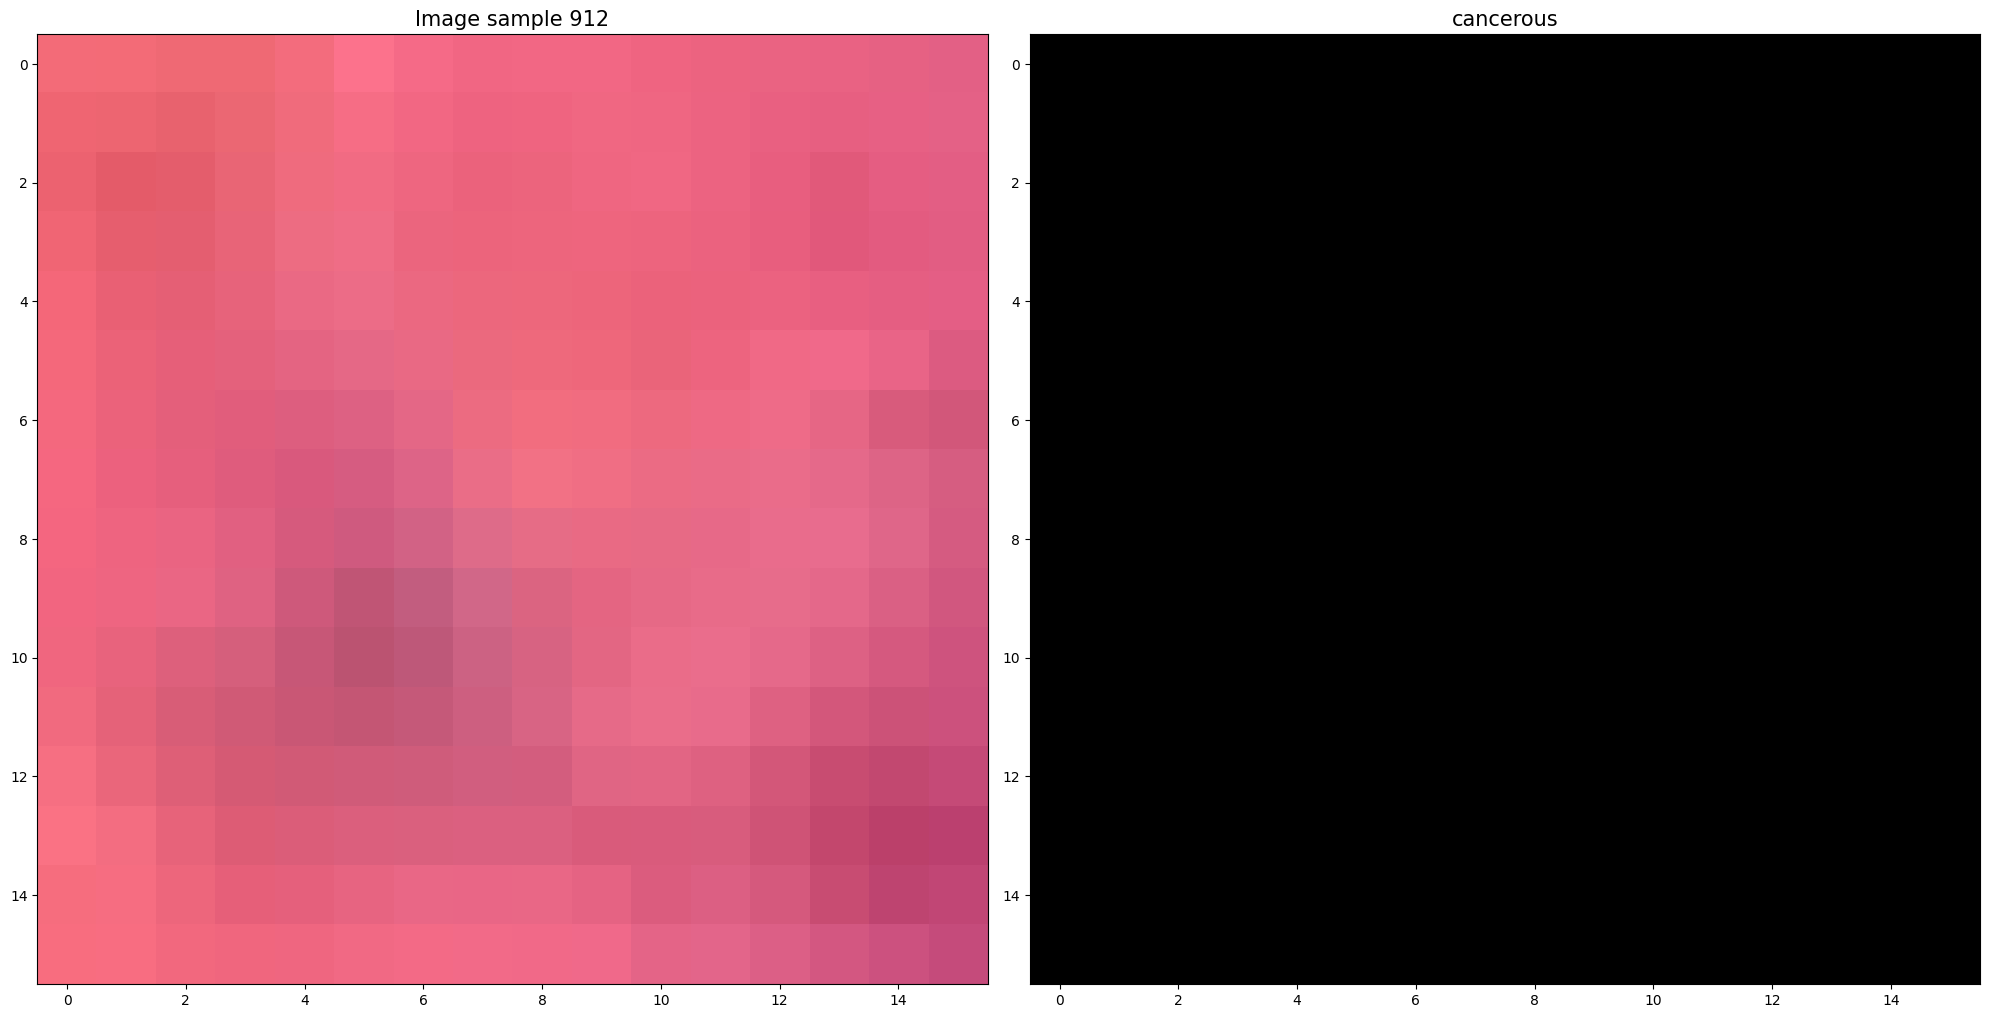

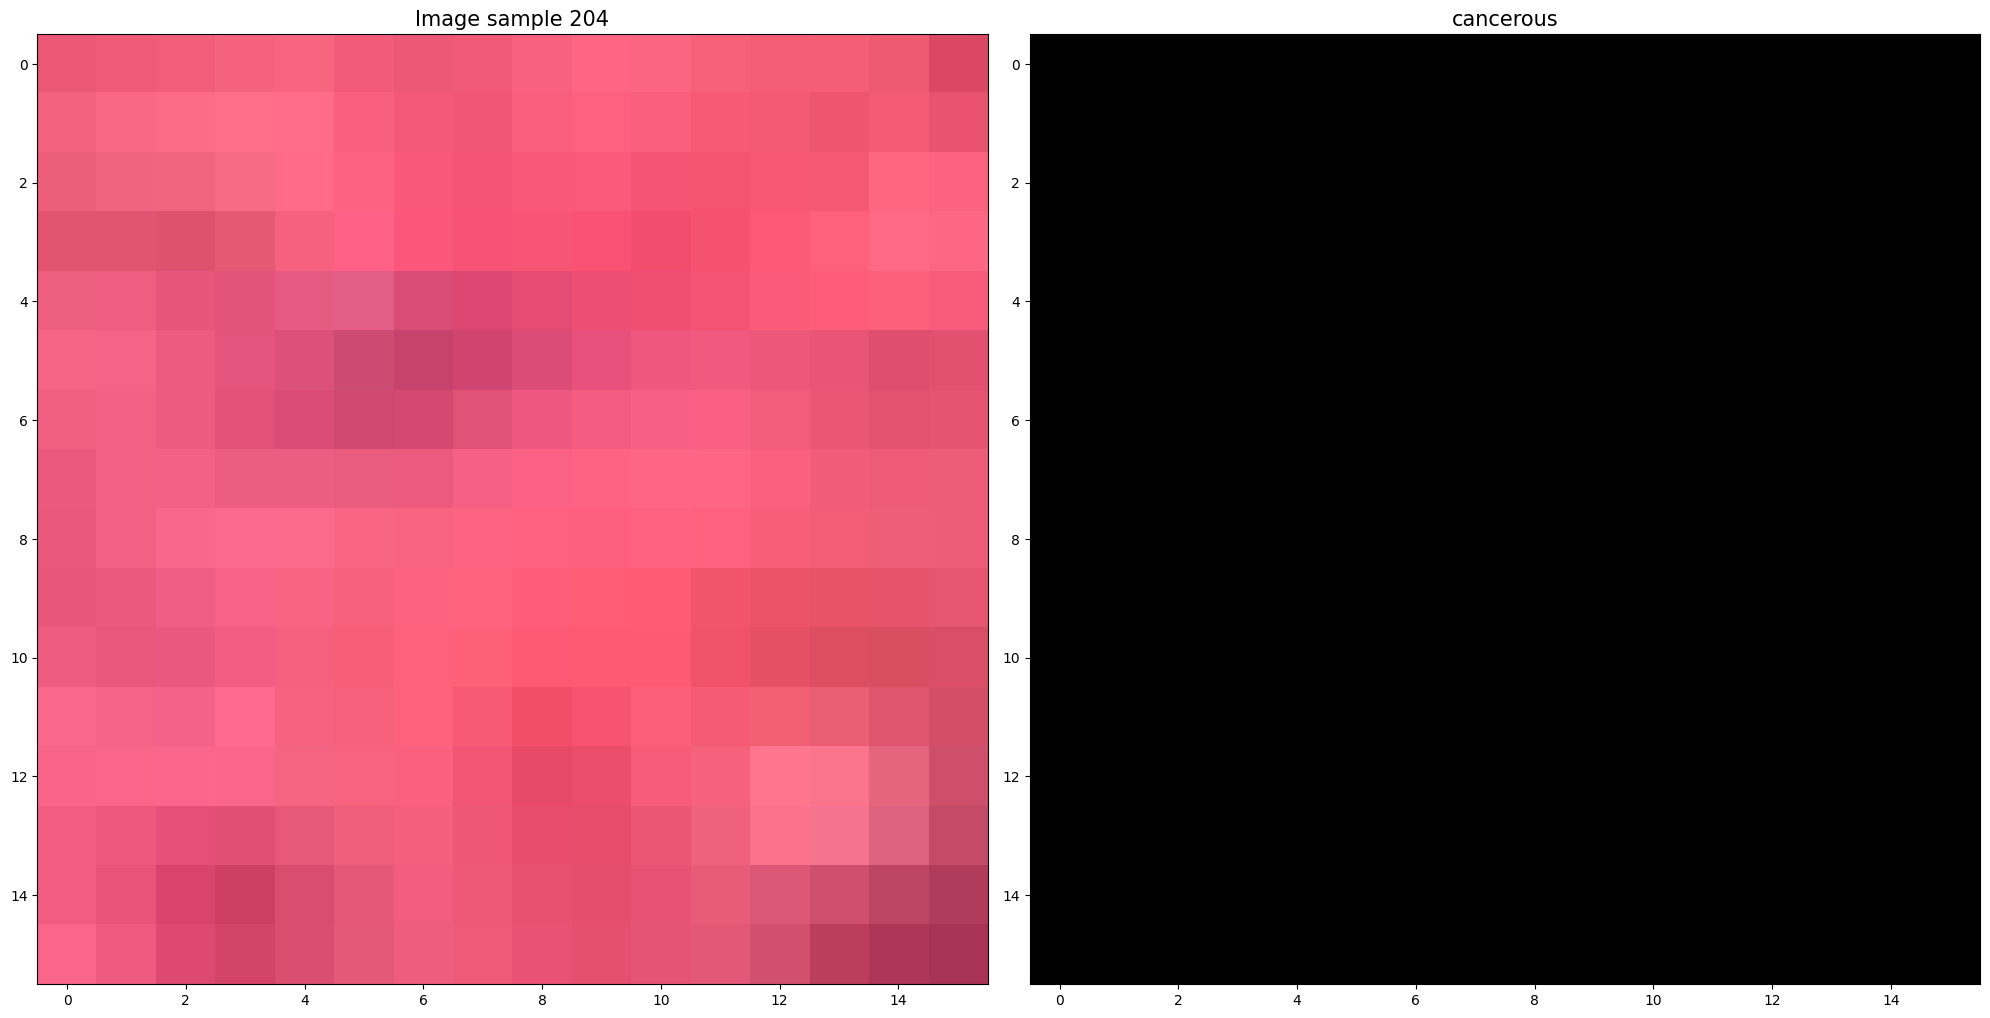

In [11]:
show_random_sample(dataset,reports_dir,CFG.experiment_id)

**FUNCTIONS (PLOTS and DICE COEFFICIENT)**

**MODEL INITIATION**

In [12]:
model = UNet(in_channels=3, num_masks=num_masks).to(CFG.device)
device = CFG.device

# loading pretrained model if available
if CFG.train_continuation == True:
    model.load_state_dict(torch.load(CFG.pretrained_model_path))

if num_masks == 1:
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# TRENOWANIE MODELU

In [13]:
#INITIATION LISTS FOR METRICS COLLECTION

# LOSS
train_average_loss_per_class_per_epoch = {name: [] for name in class_names}
val_average_loss_per_class_per_epoch = {name: [] for name in class_names}
# TIME
total_train_time = 0.0

#DICE COEF
train_average_dice_per_class_per_epoch = {name: [] for name in class_names}
val_average_dice_per_class_per_epoch = {name: [] for name in class_names}

#EARLY STOPPING
early_stopping = EarlyStopping(patience = CFG.es_patience, delta = CFG.es_delta, save_path = os.path.join(models_dir, f"model_{CFG.experiment_id}.pth"))
    
#MODEL TRAINING
for epoch in range(CFG.epochs):

    train_start_time        = time.time() #start time for train    
    train_epoch_losses      = {name: [] for name in class_names} 
    train_dice_per_class    = {name: [] for name in class_names}
    val_epoch_losses        = {name: [] for name in class_names} 
    val_dice_per_class      = {name: [] for name in class_names}

    model.train()

    for images, masks in train_loader: 
        images = images.to(device)
        masks = {key: value.to(device) for key, value in masks.items()}
        outputs = model(images) 

        train_sum_batch_loss = torch.tensor(0.0, device=device)
        
        if num_masks > 1: # multi-class segmentation
            for class_name in class_names: # cancerous,inflammatory etc.
                #loss
                target_mask_class = masks[class_name].squeeze(1).long()  #shape [8,16,16] 
                loss =criterion(outputs,target_mask_class)
                train_sum_batch_loss += loss 
                train_epoch_losses[class_name].append(loss.item()) #collecting losses for print+chart

                #dice coef
                pred_mask = (outputs.argmax(dim=1) == class_names.index(class_name)).float()  # Predicted mask for class_name
                true_mask = (target_mask_class == class_names.index(class_name)).float()  
                train_class_dice = dice_coefficient(pred_mask, true_mask) #dice
                train_dice_per_class[class_name].append(train_class_dice.item())  #accumulating dice

        else: #single-class
                class_name = class_names[0]
                #loss
                target_mask_class = masks[class_names[0]].float()  # Single class mask
                loss =criterion(outputs,target_mask_class)
                train_sum_batch_loss += loss 
                train_epoch_losses[class_name].append(loss.item()) 

                #dice
                pred_mask = (outputs.argmax(dim=1) == 0).float()  # Prediction for the single class
                true_mask = (target_mask_class == 0).float()  # Ground truth for the single class
                #dice coef
                train_class_dice = dice_coefficient(pred_mask, true_mask)
                train_dice_per_class[class_names[0]].append(train_class_dice.item())


        avg_loss_per_class = train_sum_batch_loss/num_masks 
        optimizer.zero_grad() #clear the gradient params
        avg_loss_per_class.backward() #backprogpagation on an image
        optimizer.step()

    # loss train_epoch_losses has 182 values * 2 classes, because its 8 pictures in a batch ->8*182 = train_size 1456
    for class_name in class_names:
        if train_epoch_losses[class_name]:
            train_avg_loss_per_class = sum(train_epoch_losses[class_name]) / len(train_epoch_losses[class_name])
            train_average_loss_per_class_per_epoch[class_name].append(train_avg_loss_per_class)
        else:
            train_avg_loss_per_class = None  

        # avg dice
        if train_dice_per_class[class_name]:
            train_avg_dice_per_class = sum(train_dice_per_class[class_name]) / len(train_dice_per_class[class_name])
            train_average_dice_per_class_per_epoch[class_name].append(train_avg_dice_per_class)
        else:
            avg_dice = None  # or use a specific value to indicate no Dice coefficient recorded

        # epoch results
        print(f"TRAIN Epoch {epoch+1}/{CFG.epochs}, Class: {class_name}, "
              f"Average Loss: {train_avg_loss_per_class if train_avg_loss_per_class is not None else 'No loss recorded'}, "
              f"Average Dice Coefficient: {train_avg_dice_per_class if train_avg_dice_per_class is not None else 'No dice coefficient recorded'}")

    # End timing for the TRAIN
    train_end_time = time.time()
    train_duration = train_end_time - train_start_time
    total_train_time += train_duration
    
    #MODEL VALIDATION
    
    #TIME
    total_val_time = 0.0
    
    #start time for val
    val_start_time = time.time() 

    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  #not necessary to track gradients
        for images, masks in val_loader:
            images = images.to(device)
            masks = {key: value.to(device) for key, value in masks.items()}
            outputs = model(images)  #shape [8,2,16,16] PREDICTION

            val_sum_batch_loss = torch.tensor(0.0, device=device)

            if num_masks > 1:
                for class_name in class_names:
                    #loss
                    target_mask_class = masks[class_name].squeeze(1).long()  
                    val_loss =criterion(outputs,target_mask_class)
                    val_sum_batch_loss += val_loss
                    val_epoch_losses[class_name].append(val_loss.item())

                    #dice
                    pred_mask = (outputs.argmax(dim=1) == class_names.index(class_name)).float()  # Predicted mask for class_name
                    true_mask = (target_mask_class == class_names.index(class_name)).float()
                    val_class_dice = dice_coefficient(pred_mask, true_mask)
                    val_dice_per_class[class_name].append(val_class_dice.item())
                    

            else:
                class_name = class_names[0]
                #loss
                target_mask_class = masks[class_names[0]].float()  # Single class mask
                val_loss =criterion(outputs,target_mask_class)
                val_sum_batch_loss += val_loss
                val_epoch_losses[class_name].append(val_loss.item())

                #dice
                pred_mask = (outputs.argmax(dim=1) == 0).float()  
                true_mask = (target_mask_class == 0).float()  
                val_class_dice = dice_coefficient(pred_mask, true_mask)               
                val_dice_per_class[class_names[0]].append(val_class_dice.item())
    
        # Calculate and print average loss and Dice coefficient per class for this epoch
        for class_name in class_names:
        # avg loss
            if val_epoch_losses[class_name]:
                val_avg_loss = sum(val_epoch_losses[class_name]) / len(val_epoch_losses[class_name])
                val_average_loss_per_class_per_epoch[class_name].append(val_avg_loss)
            else:
                val_avg_loss = None  

        # avg dice
            if val_dice_per_class[class_name]:
                val_avg_dice = sum(val_dice_per_class[class_name]) / len(val_dice_per_class[class_name])
                val_average_dice_per_class_per_epoch[class_name].append(val_avg_dice)
            else:
                val_avg_dice = None  # or use a specific value to indicate no Dice coefficient recorded

            # epoch results
            print(f"VALID Epoch {epoch+1}/{CFG.epochs}, Class: {class_name}, "
              f"Average Loss: {val_avg_loss if val_avg_loss is not None else 'No loss recorded'}, "
              f"Average Dice Coefficient: {val_avg_dice if val_avg_dice is not None else 'No dice coefficient recorded'}")

            # early stopping
            if ((CFG.early_stopping == True) and (num_masks == 1)):
                early_stopping(val_avg_loss, model)

    # End timing for the validation phase
    val_end_time = time.time()
    val_duration = val_end_time - val_start_time
    total_val_time += val_duration  

    # Checking if training should be stopped
    if early_stopping.early_stop == True:
        print("Early stopping triggered. Stopping training.")
        break

TRAIN Epoch 1/1, Class: cancerous, Average Loss: 0.47673714912122106, Average Dice Coefficient: 0.6746723411091845
VALID Epoch 1/1, Class: cancerous, Average Loss: 0.4242078942007417, Average Dice Coefficient: 0.6799738435878987


In [14]:
torch.save(model.state_dict(), os.path.join(models_dir, f"model_{CFG.experiment_id}.pth"))

In [15]:
train_class_loss_averages = calculate_averages_per_class(train_average_loss_per_class_per_epoch, "Train", CFG.epochs)
train_class_dice_averages = calculate_averages_per_class(train_average_dice_per_class_per_epoch, "Train", CFG.epochs)
train_overall_average_loss = calculate_overall_average(train_average_loss_per_class_per_epoch)
print_summary("training", total_train_time, train_class_loss_averages, train_class_dice_averages, train_overall_average_loss)

val_class_loss_averages = calculate_averages_per_class(val_average_loss_per_class_per_epoch, "Val", CFG.epochs)
val_class_dice_averages = calculate_averages_per_class(val_average_dice_per_class_per_epoch, "Val", CFG.epochs)
val_overall_average_loss = calculate_overall_average(val_average_loss_per_class_per_epoch)
print_summary("validation", total_val_time, val_class_loss_averages, val_class_dice_averages, val_overall_average_loss)

print("=================TOTAL TIME=======================")
total_time = total_train_time + total_val_time
print(f'Total time: {total_time:.2f} sec.')


====================TRAINING====================
====================TRAINING LOSS====================
Train_class_cancerous_average = 0.4767
====================TRAINING DICE====================
Train_class_cancerous_average = 0.6747
Overall training average loss: 0.4767
Total Training Time: 1036.10 sec
====================VALIDATION====================
====================VALIDATION LOSS====================
Val_class_cancerous_average = 0.4242
====================VALIDATION DICE====================
Val_class_cancerous_average = 0.6800
Overall validation average loss: 0.4242
Total Validation Time: 65.59 sec
=================TOTAL TIME=======================
Total time: 1101.69 sec.


**PLOTS**

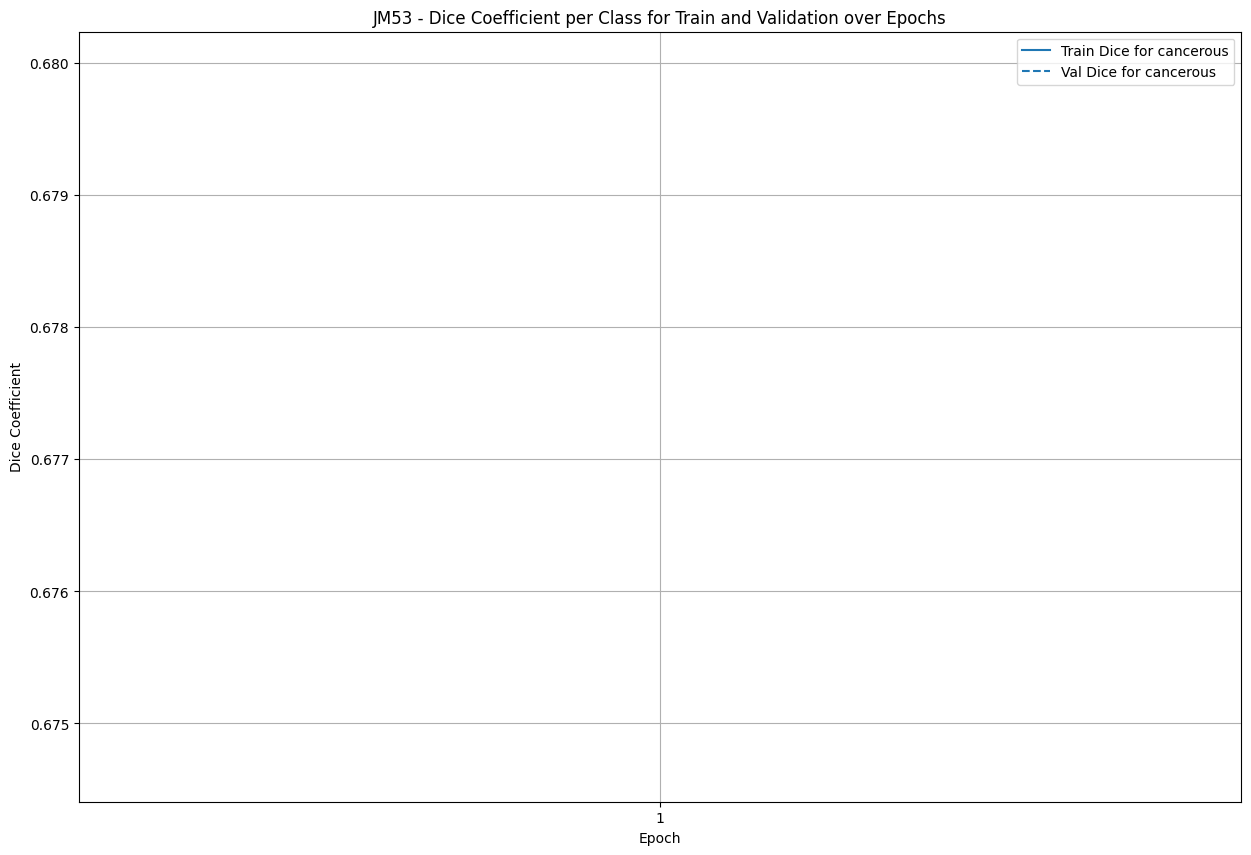

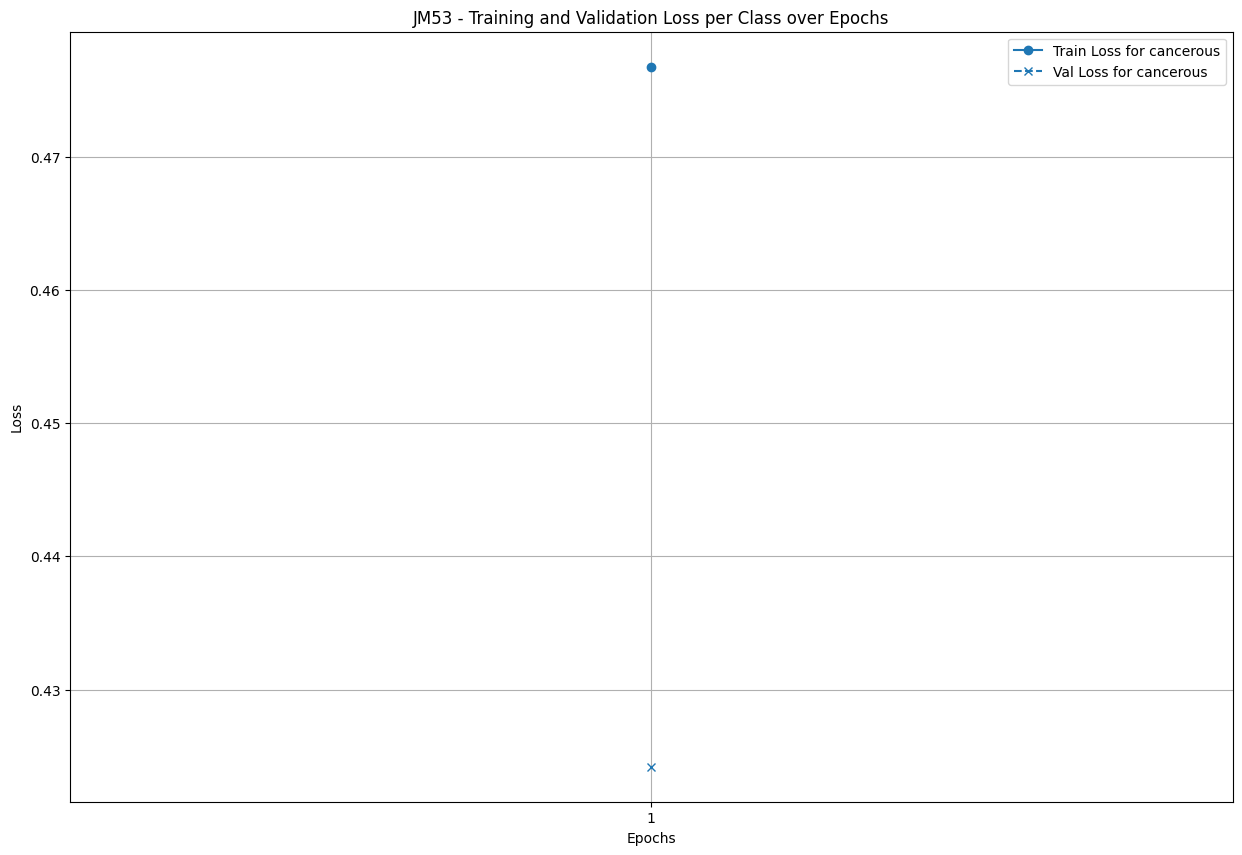

In [16]:
plot_dice_coefficients(
    train_average_dice_per_class_per_epoch,
    val_average_dice_per_class_per_epoch, 
    class_names, 
    CFG.experiment_id,
    reports_dir)
plot_learning_curve(
    train_average_loss_per_class_per_epoch,
    val_average_loss_per_class_per_epoch,
    class_names, CFG.experiment_id,reports_dir)

**VISUALISATION - PREDICTION AND OUTPUT**

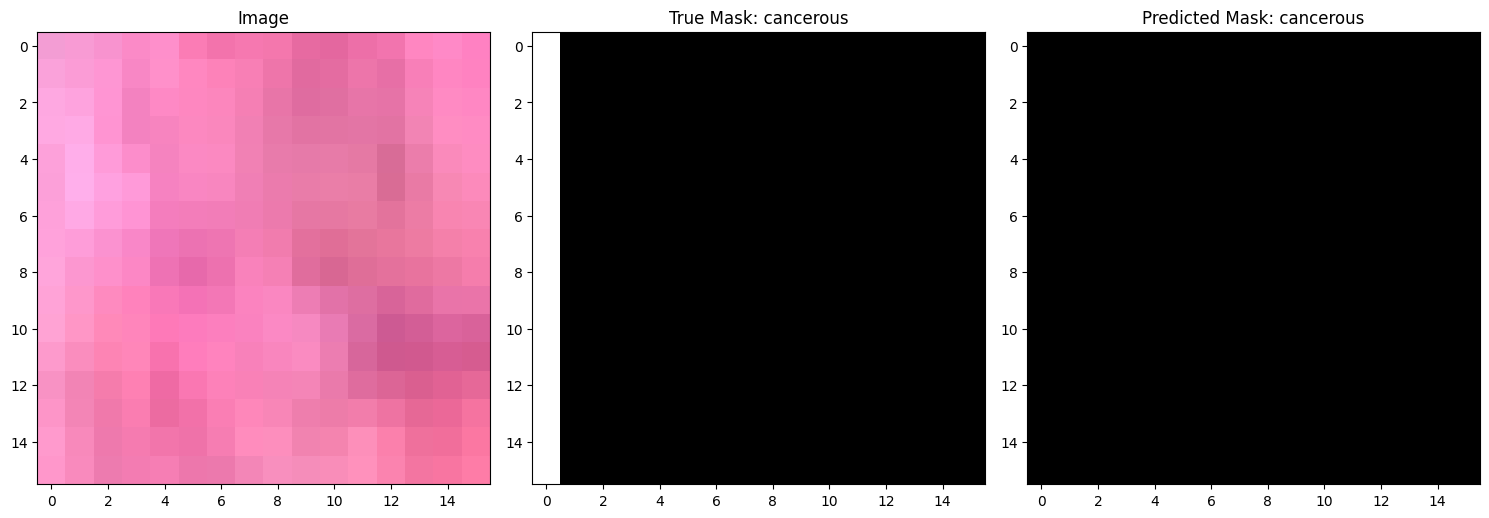

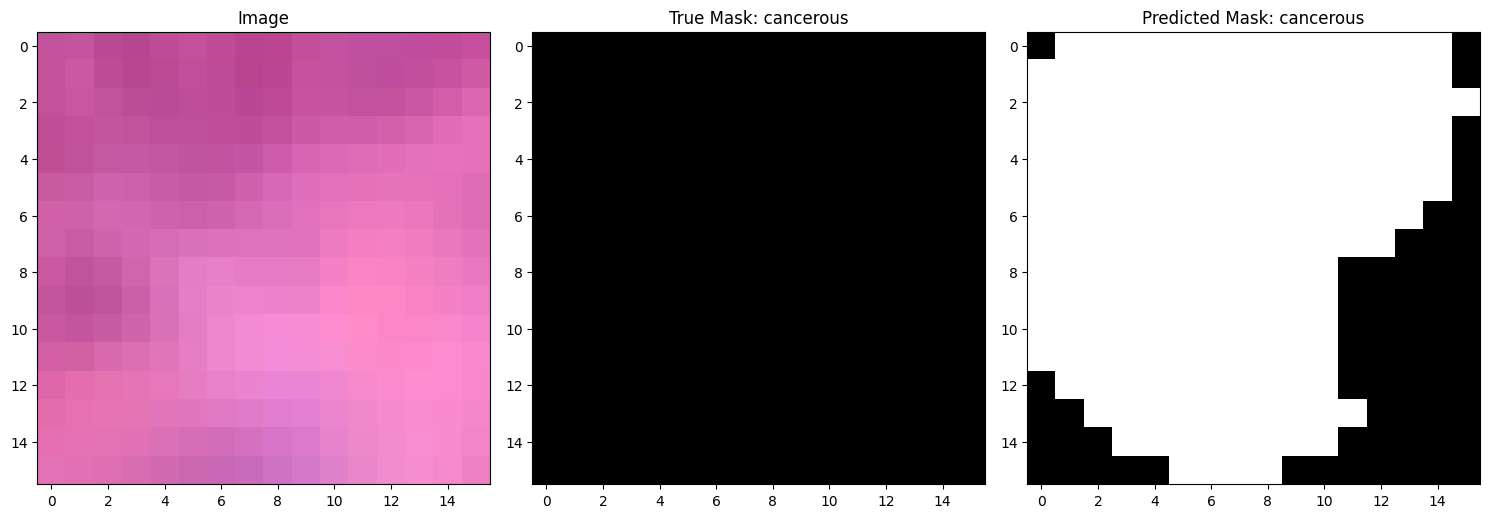

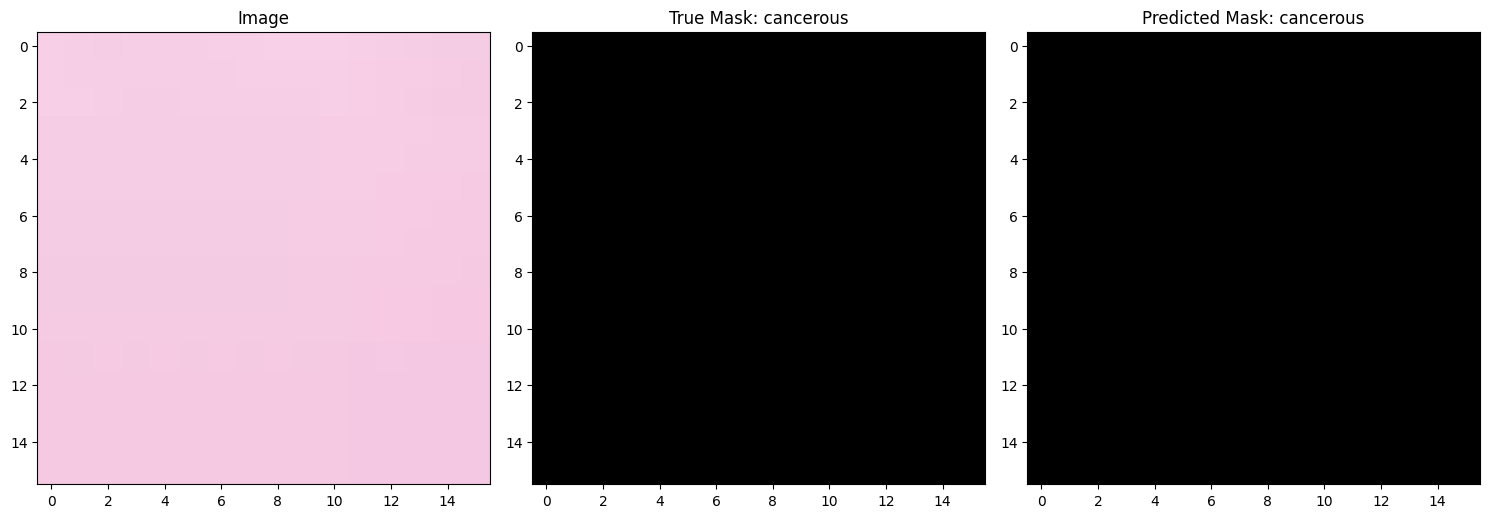

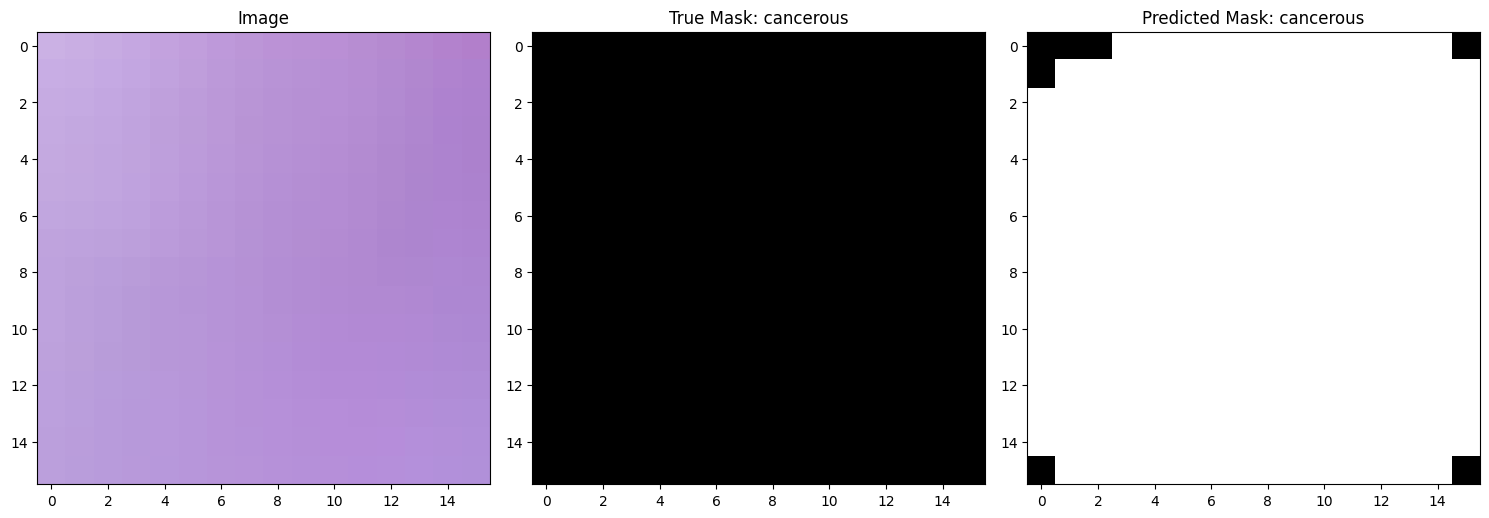

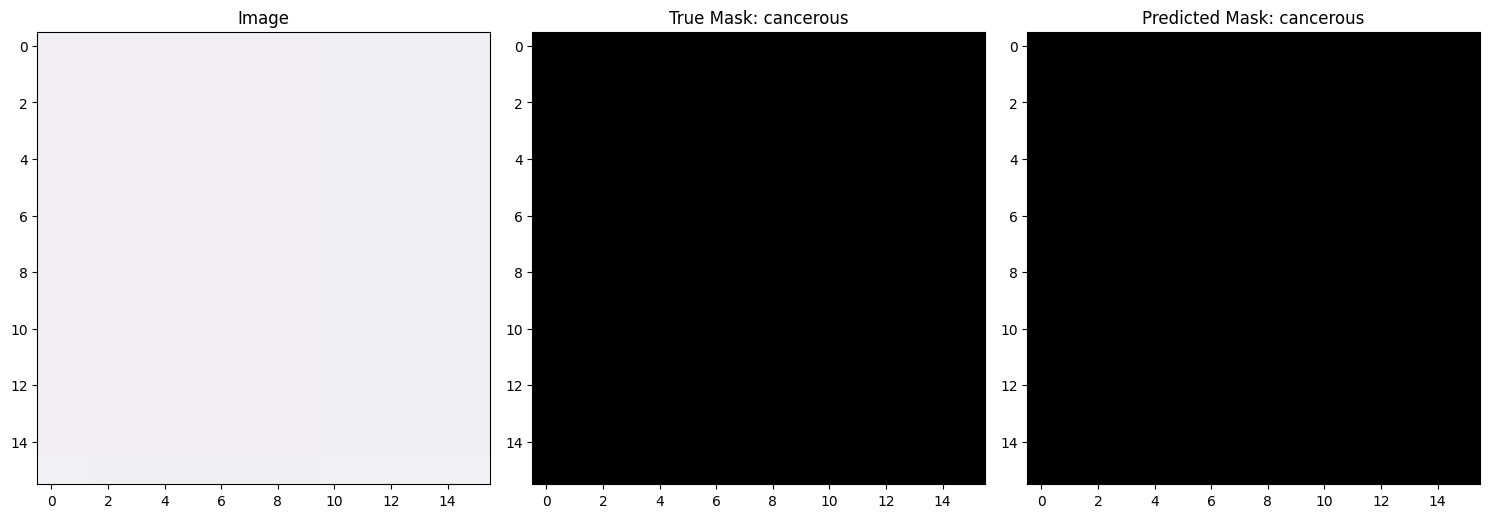

In [17]:
class_labels = mask_config
number_of_samples =5
model.eval()
visualize_predictions(model, val_dataset, device, class_labels, number_of_samples, reports_dir, CFG.experiment_id)

## TEST

In [18]:
def evaluate_model_on_test_data():
    model.eval()
    test_epoch_losses = {name: [] for name in class_names}
    test_dice_per_class = {name: [] for name in class_names}

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = {key: value.to(device) for key, value in masks.items()}
            outputs = model(images)

            test_sum_batch_loss = torch.tensor(0.0, device=device)

            if num_masks > 1:
                for class_name in class_names:
                    target_mask_class = masks[class_name].squeeze(1).long()
                    test_loss = criterion(outputs, target_mask_class)
                    test_sum_batch_loss += test_loss
                    test_epoch_losses[class_name].append(test_loss.item())

                    pred_mask = (outputs.argmax(dim=1) == class_names.index(class_name)).float()
                    true_mask = (target_mask_class == class_names.index(class_name)).float()
                    test_class_dice = dice_coefficient(pred_mask, true_mask)
                    test_dice_per_class[class_name].append(test_class_dice.item())
            else:
                class_name = class_names[0]
                target_mask_class = masks[class_name].float()
                test_loss = criterion(outputs, target_mask_class)
                test_sum_batch_loss += test_loss
                test_epoch_losses[class_name].append(test_loss.item())

                pred_mask = (outputs.argmax(dim=1) == 0).float()
                true_mask = (target_mask_class == 0).float()
                test_class_dice = dice_coefficient(pred_mask, true_mask)
                test_dice_per_class[class_name].append(test_class_dice.item())

    # Calculate per-class average loss and Dice coefficient for the test dataset
    test_loss = {}
    test_dice = {}

    for class_name in class_names:
        if test_epoch_losses[class_name]:
            test_avg_loss = sum(test_epoch_losses[class_name]) / len(test_epoch_losses[class_name])
            test_loss[class_name] = test_avg_loss
            print(f"TEST Class: {class_name}, Average Loss: {test_avg_loss:.4f}")
        else:
            test_loss[class_name] = 0.0
            print(f"TEST Class: {class_name}, No loss recorded")

        if test_dice_per_class[class_name]:
            test_avg_dice = sum(test_dice_per_class[class_name]) / len(test_dice_per_class[class_name])
            test_dice[class_name] = test_avg_dice
            print(f"TEST Class: {class_name}, Average Dice Coefficient: {test_avg_dice:.4f}")
        else:
            test_dice[class_name] = 0.0
            print(f"TEST Class: {class_name}, No Dice Coefficient recorded")

    return test_loss, test_dice

if __name__ == "__main__":
    test_loss, test_dice = evaluate_model_on_test_data()

TEST Class: cancerous, Average Loss: 0.4384
TEST Class: cancerous, Average Dice Coefficient: 0.6591


### OUTPUT DATA TRACKING FOR A REPORT

#### REPORT DEFINITION & OUTPUT

In [19]:
all_classes = ["cancerous", "hard_to_classify", "inflammatory", "stroma"]

train_dice = calculate_dice_for_report(enabled_masks, train_average_dice_per_class_per_epoch,all_classes)
val_dice = calculate_dice_for_report(enabled_masks, val_average_dice_per_class_per_epoch,all_classes)

train_loss = calculate_loss_for_report(train_average_loss_per_class_per_epoch,all_classes)
val_loss = calculate_loss_for_report(val_average_loss_per_class_per_epoch,all_classes)

train_overall_average_all_classes = np.mean(list(train_loss.values()))
val_overall_average_all_classes = np.mean(list(val_loss.values()))

current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

report = {
'Date and Time': current_time,  
'experiment_ID': CFG.experiment_id,
'included classes': class_names,
'model_name': CFG.model_name,
'train batch size (train_bs)': CFG.train_bs,
'valid batch size (val_bs)': CFG.valid_bs,
'Train size': train_size,
'Val size': val_size,
'crop size': CFG.crop_size,
'number of crops (num_crops)': CFG.num_crops,
'epochs': CFG.epochs,
'learning rate (lr)': CFG.lr,
'device': str(CFG.device), 
'CNN Model parameters': str(model),
'optimizer': str(optimizer),
'criterion': str(criterion),
'Number of params': total_params,
'Train total time': f'{total_train_time:.2f} sec',
'Val total time': f'{total_val_time:.2f} sec',
'All time': f'{total_train_time + total_val_time:.2f} sec',
'Train overall avg loss': f'{train_overall_average_all_classes:.4f}',
'Val overall avg loss': f'{val_overall_average_all_classes:.4f}',
**{f'Train Loss {class_name}': f"{train_loss[class_name]:.4f}" for class_name in class_names},
**{f'Val Loss {class_name}': f"{val_loss[class_name]:.4f}" for class_name in class_names},
**{f'Test Loss {class_name}': f"{test_loss[class_name]:.4f}" for class_name in class_names},
**{f'Train Dice {class_name}': f"{train_dice[class_name]:.4f}" for class_name in class_names},
**{f'Val Dice {class_name}': f"{val_dice[class_name]:.4f}" for class_name in class_names},
**{f'Test Dice {class_name}': f"{test_dice[class_name]:.4f}" for class_name in class_names},
'GPU': str(GPU_used)  
}   

update_report(report,CFG.experiment_id,reports_dir)